In [1]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings

In [2]:
# Import AGNI
ROOT_DIR = abspath(pwd(),"../")
using AGNI

# Disable logging from AGNI module
AGNI.setup_logging("",1)

In [3]:
R_earth = 6.371e6
M_earth = 5.972e24
S_earth = 1362.0

1362.0

In [4]:
# Configuration options
instellation    = 5.01*S_earth
mass            = 2.31*M_earth
radius          = 1.304*R_earth
gravity         = 6.67e-11 * mass / radius^2
p_surf          = 1e3
tmp_surf        = 3000.0
s0_fact         = 0.25
zenith_degrees  = 54.74
albedo_b        = 0.0
nlev_centre     = 38
p_top           = 1e-5      # bar

x_H2O = 0.01
mole_fractions  = Dict([
                        ("H2O", x_H2O),
                        ("H2" , 1-x_H2O)
                    ])
thermo          = true
real_gas        = true

phys.ENABLE_AQUA = true

albedo_data   = joinpath(ROOT_DIR,"res/surface_albedos/lunar_marebasalt.dat")
spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Dayspring/48/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

"/Users/nichollsh/Projects/AGNI/out/"

In [5]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

In [6]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, s0_fact, albedo_b, zenith_degrees,
                        tmp_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",

                        flux_int = 0.0,
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        real_gas=real_gas,
                        thermo_functions=thermo,
                        surface_material=albedo_data
                    )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Setting-up a new atmosphere struct 
[ INFO  ] Loading thermodyamic data 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocating atmosphere with composition: 
[ INFO  ]       1 H2O     1.00e-02 (EOS_AQUA) 
[ INFO  ]       2 H2      9.90e-01 (EOS_CMS19) 


true

In [7]:
x_arr = collect(Float64, range(0.95, 0.05, length=4))
nsamps = length(x_arr)
display(nsamps)
display(x_arr)

4

4-element Vector{Float64}:
 0.95
 0.65
 0.35
 0.05

In [8]:
atm_con_ide = atmosphere.Atmos_t[] # convective, ideal
atm_con_rea = atmosphere.Atmos_t[] # convective, real
@printf("Running convective model for 2*%d samples... \n", nsamps)
for i in 1:nsamps
    @printf("    sample %d/%d \n",i,nsamps)

    # update planet
    x_H2O = x_arr[i]
    println("    x_H2O = $x_H2O")
    fill!(atmos.gas_vmr["H2O"], x_H2O)
    fill!(atmos.gas_vmr["H2"], 1-x_H2O)

    # set ideal
    atmos.gas_dat["H2O"].eos = phys.EOS_IDEAL
    atmos.gas_dat["H2"].eos = phys.EOS_IDEAL

    # run convective
    println("    con-ide")
    setpt.dry_adiabat!(atmos)
    setpt.saturation!(atmos, "H2O")
    energy.calc_fluxes!(atmos, false, true, true, false)
    atmosphere.calc_observed_rho!(atmos)
    push!(atm_con_ide, deepcopy(atmos))

    # set real gas
    atmos.gas_dat["H2O"].eos = phys.EOS_AQUA
    atmos.gas_dat["H2"].eos = phys.EOS_CMS19

    # run convective
    println("    con-rea")
    setpt.dry_adiabat!(atmos)
    setpt.saturation!(atmos, "H2O")
    energy.calc_fluxes!(atmos, false, true, true, false)
    atmosphere.calc_observed_rho!(atmos)
    push!(atm_con_rea, deepcopy(atmos))

    @printf("--------------------------------- \n")
end

rtol = 0.1
lins = 0
atm_sol_ide = atmosphere.Atmos_t[] # solved, ideal
atm_sol_rea = atmosphere.Atmos_t[] # solved, real
@printf("Running radiative-convective model for 2*%d samples... \n", nsamps)
setpt.stratosphere!(atmos, 500.0)
for i in 1:nsamps
    @printf("    sample %d/%d \n",i,nsamps)

    # update planet
    x_H2O = x_arr[i]
    println("    x_H2O = $x_H2O")
    fill!(atmos.gas_vmr["H2O"], x_H2O)
    fill!(atmos.gas_vmr["H2"], 1-x_H2O)

    # set ideal
    atmos.gas_dat["H2O"].eos = phys.EOS_IDEAL
    atmos.gas_dat["H2"].eos = phys.EOS_IDEAL

    # run RCE
    println("    sol-ide")
    solver.solve_energy!(atmos, save_frames=false, ls_method=lins, conv_rtol=rtol, dx_max=100.0)
    atmosphere.calc_observed_rho!(atmos)
    push!(atm_sol_ide, deepcopy(atmos))

    # set real gas
    atmos.gas_dat["H2O"].eos = phys.EOS_VDW
    atmos.gas_dat["H2"].eos = phys.EOS_CMS19

    # run RCE
    println("    sol-rea")
    solver.solve_energy!(atmos,save_frames=false, ls_method=lins, conv_rtol=rtol, dx_max=50.0)
    atmosphere.calc_observed_rho!(atmos)
    push!(atm_sol_rea, deepcopy(atmos))

    @printf("--------------------------------- \n")
end


println("Done!")

Running convective model for 2*4 samples... 
    sample 1/4 
    x_H2O = 0.95
    con-ide
    con-rea
--------------------------------- 
    sample 2/4 
    x_H2O = 0.65
    con-ide
    con-rea
--------------------------------- 
    sample 3/4 
    x_H2O = 0.35
    con-ide
    con-rea
--------------------------------- 
    sample 4/4 
    x_H2O = 0.05
    con-ide
    con-rea
--------------------------------- 
Running radiative-convective model for 2*4 samples... 
    sample 1/4 
    x_H2O = 0.95
    sol-ide
[ INFO  ]     chem_type = 0 
[ INFO  ]     sol_type  = 1 
[ INFO  ]     tmp_surf  = 3000.00 K 
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags 
[ INFO  ]        1  -1.66e+01  2.792e+08  2.847e+03  2.999e+03  1.000e+02  C2-Nr 
[ INFO  ]        2  -1.18e+01  1.953e+08  2.282e+03  2.999e+03  1.000e+02  C2-Nr 
[ INFO  ]        3  -7.59e+00  1.271e+08  1.795e+03  3.000e+03  1.000e+02  C2-Nr 
[ INFO  ]        4  -6.88e+00  7.357e+07  1.449e+03  3.000e+03 

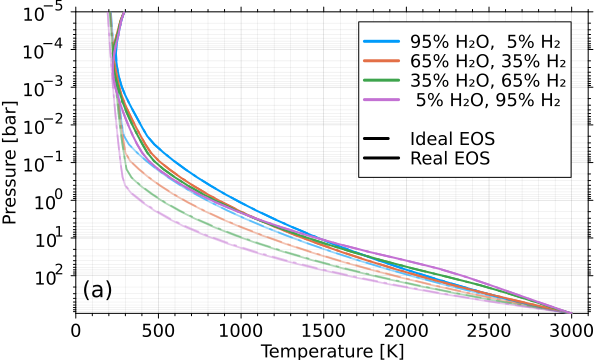

[ WARN  ] No strict ticks found 
[ WARN  ] No strict ticks found 
[ WARN  ] No strict ticks found 
[ WARN  ] No strict ticks found 
[ WARN  ] No strict ticks found 
[ WARN  ] No strict ticks found 
[ WARN  ] No strict ticks found 
[ WARN  ] No strict ticks found 
[ WARN  ] No strict ticks found 


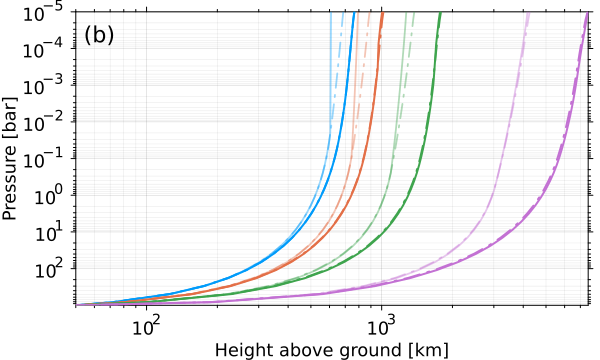

"/Users/nichollsh/Projects/AGNI/out/struct_pz.pdf"

In [121]:
fs = 12
figscale = 1.2

arr_P = atmos.pl / 1.0e5 # Convert Pa to bar
ylims  = (arr_P[1], arr_P[end])
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

props = Dict((
    :size          =>(500*figscale,300*figscale),
    :framestyle    =>:box,
    :tickfontsize  =>fs,
    :guidefontsize =>fs,
    :legendfontsize=>fs,
    :tick_direction=>:out,
    :ylabel => "Pressure [bar]",
))
axl = plot(xlabel="Temperature [K]", legend=:topright; props...)
axr = plot(xlabel="Height above ground [km]"; props...)

z0 = 50.0
function r2z(rl)
    return (rl .- radius) ./ 1e3 .+ z0
end

p = Plots.palette(:default)
lw = 2.0
al = 1.0
ide_sty=:dashdot
rea_sty=:solid
for i in 1:nsamps
    c = p[i]

    # solved
    _lw = lw
    _al = al
    lbl = @sprintf(" %2.0f%% H₂O, %2.0f%% H₂", x_arr[i]*100, (1-x_arr[i])*100)

    # real gas (solid, thick)
    dat = atm_sol_rea[i]
    plot!(axl, dat.tmpl,    dat.pl/1e5, lc=c, alpha=_al, lw=_lw, ls=rea_sty, label=lbl)
    plot!(axr, r2z(dat.rl), dat.pl/1e5, lc=c, alpha=_al, lw=_lw, ls=rea_sty, label="")

    # ideal gas (dashed, thick)
    dat = atm_sol_ide[i]
    plot!(axl, dat.tmpl,    dat.pl/1e5, lc=c, alpha=_al, lw=_lw, ls=ide_sty, label="")
    plot!(axr, r2z(dat.rl), dat.pl/1e5, lc=c, alpha=_al, lw=_lw, ls=ide_sty, label="")

    # adiabatic
    _lw = lw * 0.9
    _al = al * 0.4

    # real gas (solid, thin)
    dat = atm_con_rea[i]
    plot!(axl, dat.tmpl,    dat.pl/1e5, lc=c, alpha=_al, lw=_lw, ls=rea_sty, label="")
    plot!(axr, r2z(dat.rl), dat.pl/1e5, lc=c, alpha=_al, lw=_lw, ls=rea_sty, label="")

    # ideal gas (dashed, thin)
    dat = atm_con_ide[i]
    plot!(axl, dat.tmpl,    dat.pl/1e5, lc=c, alpha=_al, lw=_lw, ls=ide_sty, label="")
    plot!(axr, r2z(dat.rl), dat.pl/1e5, lc=c, alpha=_al, lw=_lw, ls=ide_sty, label="")
end

# legend entries
plot!(axl, [-5, -4], [1, 1], lc=:white, alpha=al, lw=lw, label="  ")
plot!(axl, [-5, -4], [1, 1], lc=:black, alpha=al, lw=lw, ls=ide_sty, label=" Ideal EOS")
plot!(axl, [-5, -4], [1, 1], lc=:black, alpha=al, lw=lw, ls=rea_sty, label=" Real EOS")


# configure axes
for ax in (axl, axr)
    yflip!(ax)
    yaxis!(ax, yscale=:log10,ylims=ylims, yticks=yticks)
end
xlims = (0.0, 3000.0)
dx = 500
xaxis!(axl, minorgrid=true, xlims=(xlims[1], xlims[2]+100), xticks=range(xlims[1], xlims[2], step=dx))
xaxis!(axr, scale=:log10, xlims=(z0, Inf), minorgrid=true, bottom_margin=2Plots.mm)

annotate!(axl, 50,     ylims[2]/2, [text("(a)", :bottom, :left, 15)])
annotate!(axr, z0*1.1, ylims[1]*2, [text("(b)", :top,    :left, 15)])

# show and save plots
display(axl)
savefig(axl, joinpath(output_dir,"struct_pt.pdf"))
display(axr)
savefig(axr, joinpath(output_dir,"struct_pz.pdf"))

In [33]:
for i in 1:nsamps

    lbl = @sprintf("%03d", x_arr[i]*100)

    # real gas (solid, thick)
    dat = atm_sol_rea[i]
    AGNI.save.write_ncdf(dat, joinpath(output_dir, "atm_sol_rea_$lbl.nc"))

    # ideal gas (dashed, thick)
    dat = atm_sol_ide[i]
    AGNI.save.write_ncdf(dat, joinpath(output_dir, "atm_sol_ide_$lbl.nc"))

    # ----------------------

    # real gas (solid, thin)
    dat = atm_con_rea[i]
    AGNI.save.write_ncdf(dat, joinpath(output_dir, "atm_con_rea_$lbl.nc"))

    # ideal gas (dashed, thin)
    dat = atm_con_ide[i]
    AGNI.save.write_ncdf(dat, joinpath(output_dir, "atm_con_ide_$lbl.nc"))

end

println("Done")

[ WARN  ] Can not determine size of element type. Using DiskArrays.fallback_element_size[] = 100 bytes 
[ WARN  ] Can not determine size of element type. Using DiskArrays.fallback_element_size[] = 100 bytes 
[ WARN  ] Can not determine size of element type. Using DiskArrays.fallback_element_size[] = 100 bytes 
[ WARN  ] Can not determine size of element type. Using DiskArrays.fallback_element_size[] = 100 bytes 
[ WARN  ] Can not determine size of element type. Using DiskArrays.fallback_element_size[] = 100 bytes 
[ WARN  ] Can not determine size of element type. Using DiskArrays.fallback_element_size[] = 100 bytes 
[ WARN  ] Can not determine size of element type. Using DiskArrays.fallback_element_size[] = 100 bytes 
[ WARN  ] Can not determine size of element type. Using DiskArrays.fallback_element_size[] = 100 bytes 
[ WARN  ] Can not determine size of element type. Using DiskArrays.fallback_element_size[] = 100 bytes 
[ WARN  ] Can not determine size of element type. Using DiskArra